In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
os.environ["xai_api_key"]=os.getenv("X_AI")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


In [3]:
from langchain_xai import ChatXAI
from langchain_groq import ChatGroq

In [4]:
#XAI for News
News_llm = ChatXAI(model="grok-2")

#OpenSource llm for Summary generator
#Grog for Summary generator & Validate the User input
llm=ChatGroq(model="qwen-2.5-32b")



In [5]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph,END
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from typing_extensions import TypedDict

In [6]:
# System message
sys_msg = SystemMessage(content="You News Blog/Article Generator assistance - help with Top 5 news for requested Country/Area")

In [7]:
# Graph state
class State(TypedDict, total=False):
    country: str
    news_column: str
    input_status: str
    news: str
    summary_news: str


In [8]:
## get user input
def get_user_input(state: State):
    country = input("Please enter the Country/Area for which you want to get the news: ")
    column_name = input("Please enter the news column (e.g., Politics, Sports, Business): ")
    print("Country/Area: ", country)
    print("News Column: ", column_name)
    return {"country": country, "news_column": column_name}

In [9]:
def get_news(state: State):
    """
    Get news from the News LLM
    """
    # Get the country from the state
    country = state["country"]
    # Get the column name from the state
    column = state["news_column"]
    # Get the news from the News LLM
    msg = News_llm.invoke(f"Get me Top 5 news for {country} news for {column},  check for factual and should not be baised/Sensitve news")
    # Return the news
    return {"news": msg.content}

def get_summary(state: State):
    msg = llm.invoke(f"Summarize the news and have the headings/ Topics along with summary: {state['news']}")
    return {"summary_news": msg.content}  # Use lowercase "summary_news"



In [10]:

def validate_user_input(state: State):
    """
    Check if the user input is valid
    """
    # Get the country & column from the state and validate it using Groq llm
    country = state["country"]
    column_name = state["news_column"]
    
    msg = llm.invoke(

        f"Validate if '{country}' is a real country and '{column_name}' is a valid news category. "
        f"Respond ONLY with 'True' (if valid) or 'False' (if invalid). Do not include any extra words."

    )
    print(msg.content)

    is_valid = msg.content.strip().lower() == "true"
    return {"input_status": is_valid}


In [ ]:
def route_input(state: State):
    """
    Route the input to the appropriate tool based on the input status"""

    if state["input_status"] == True:
        print("Accepted")
        return "Accepted"
    elif state["input_status"] == False:
        print("Rejected")
        return "Rejected"

In [12]:
# Graph
Newsbuilder = StateGraph(State)

In [13]:
Newsbuilder.add_node("get_user_input", get_user_input)
Newsbuilder.add_node("get_news", get_news)
Newsbuilder.add_node("get_summary", get_summary)
Newsbuilder.add_node("validate_user_input", validate_user_input)


Newsbuilder.add_edge(START, "get_user_input")
Newsbuilder.add_edge("get_user_input", "validate_user_input")
#Newsbuilder.add_edge("validate_user_input", "get_news")
Newsbuilder.add_edge("get_news", "get_summary")
Newsbuilder.add_edge("get_summary", END)



Newsbuilder.add_conditional_edges(
    "validate_user_input",
    route_input,
    {
        "Accepted": "get_news",
        "Rejected": "get_user_input"
    }
)


graph = Newsbuilder.compile()

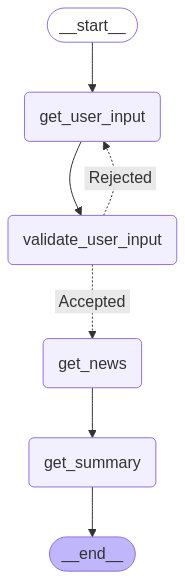

In [15]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
state = graph.invoke({"country": "", "news_column": ""}) 

Country/Area:  Australia
News Column:  Weather
True
Accepted


In [17]:
from IPython.display import Markdown
Markdown(state ['summary_news'])

### Top 5 Weather-Related News Stories for Australia

#### 1. **Heatwave Alert for Eastern Australia**
   - **Summary**: Eastern states of Australia, including New South Wales, Queensland, and Victoria, are facing a heatwave with temperatures expected to exceed 40°C in some inland areas. Health authorities are urging the public to take preventive measures against heat-related illnesses.

#### 2. **Cyclone Watch in Northern Queensland**
   - **Summary**: A tropical low in the Coral Sea is under observation for potential cyclone development. Northern Queensland's coastal areas are on cyclone watch, with authorities advising residents to prepare for severe weather conditions.

#### 3. **Heavy Rainfall and Flooding in Tasmania**
   - **Summary**: Tasmania has seen substantial rainfall leading to localized flooding. The State Emergency Service is managing flood-related emergencies, advising residents to stay updated with weather alerts.

#### 4. **Cooler Temperatures and Showers in South Australia**
   - **Summary**: South Australia is experiencing a transition to cooler weather, including showers. This change benefits agricultural activities, aiding in crop growth after prolonged dry conditions.

#### 5. **Bushfire Risk Increases in Western Australia**
   - **Summary**: Western Australia faces elevated bushfire risks due to hot and dry conditions. Firefighters and the public are on alert, with total fire bans in place and emergency preparedness emphasized.

These summaries are based on reports from official meteorological and emergency services, ensuring accurate and unbiased coverage of the current weather conditions in Australia.